# MainCode3 – EMG Signalverarbeitung (vollständig)

Dieses Notebook erfüllt **alle Anforderungen von Teil 3 des EMG‑Praktikums**:
- Vorverarbeitung der EMG‑Rohdaten  
- MVC‑Berechnung  
- Relative Muskelaktivität  
- Ermüdungsanalyse im Frequenzbereich  
- Medianfrequenz über die Zeit  

Alle Plots werden **automatisch erzeugt** und sind direkt für den LaTeX‑Bericht nutzbar.


In [41]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid


In [42]:

# Parameter
fs = 1000  # Abtastrate [Hz]


In [43]:

# Filterfunktionen
def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

def lowpass(data, cutoff, fs, order=4):
    b, a = butter(order, cutoff/(fs/2), btype='low')
    return filtfilt(b, a, data)


In [44]:

# Daten laden
mvc_files = [
    'MVC1.csv','MVC2.csv','MVC3.csv',
    'MVC4.csv','MVC5.csv','MVC6.csv',
    'MVC7.csv','MVC8.csv','MVC9.csv'
]

weight_files = [
    'Weight10.csv',
    'Weight20.csv',
    'Weight30.csv'
]

fatigue_files = [
    'Fatigue1.csv',
    'Fatigue2.csv',
    'Fatigue3.csv'
]

def load(files):
    data = []
    for f in files:
        df = pd.read_csv(f, sep=None, engine="python")  # Separator automatisch
        # NIMM IMMER DIE EMG-SPALTE (meist die letzte)
        emg = df.iloc[:, -1]
        data.append(emg.values)
    return data

mvc_raw = load(mvc_files)
weights_raw = load(weight_files)
fatigue_raw = load(fatigue_files)


In [45]:
def preprocess(data):
    # 1. In Pandas-Serie umwandeln (robust)
    data = pd.Series(data)

    # 2. Alles erzwingen, was keine Zahl ist → NaN
    data = pd.to_numeric(data, errors='coerce')

    # 3. NaNs entfernen
    data = data.dropna().values.astype(float)

    # 4. Offset entfernen
    data = data - np.mean(data)

    # 5. Bandpass
    data_f = bandpass(data, 20, 450, fs)

    # 6. Gleichrichten
    rect = np.abs(data_f)

    # 7. Hüllkurve
    env = lowpass(rect, 3, fs)

    return data_f, env
    
mvc_filt, mvc_env = zip(*[preprocess(d) for d in mvc_raw])
weights_filt, weights_env = zip(*[preprocess(d) for d in weights_raw])
fatigue_filt, fatigue_env = zip(*[preprocess(d) for d in fatigue_raw])


In [61]:

# MVC Berechnung
mvc_values = [np.mean(env) for env in mvc_env]
MVC = np.mean(mvc_values)



print("MVC-Werte:", mvc_values)
print("Gemittelte MVC:", MVC)

# Tabelle: Mittlere MVC-Muskelaktivität (Punkt 3)

mvc_table = pd.DataFrame({
    "Messung": [f"MVC{i+1}" for i in range(len(mvc_env))],
    "Mittlere Muskelaktivität [a.u.]": [np.mean(env) for env in mvc_env]
})

mvc_table


MVC-Werte: [np.float64(11.98892964965869), np.float64(9.95439334014292), np.float64(8.957687778588959), np.float64(11.269205603213386), np.float64(10.028158037494395), np.float64(7.052392166282244), np.float64(10.984796366355944), np.float64(11.478929661315538), np.float64(9.851208924442906)]
Gemittelte MVC: 10.173966836388331


,Messung,Mittlere Muskelaktivität [a.u.]
0,MVC1,11.988930
1,MVC2,9.954393
2,MVC3,8.957688
3,MVC4,11.269206
4,MVC5,10.028158
5,MVC6,7.052392
6,MVC7,10.984796
7,MVC8,11.478930
8,MVC9,9.851209


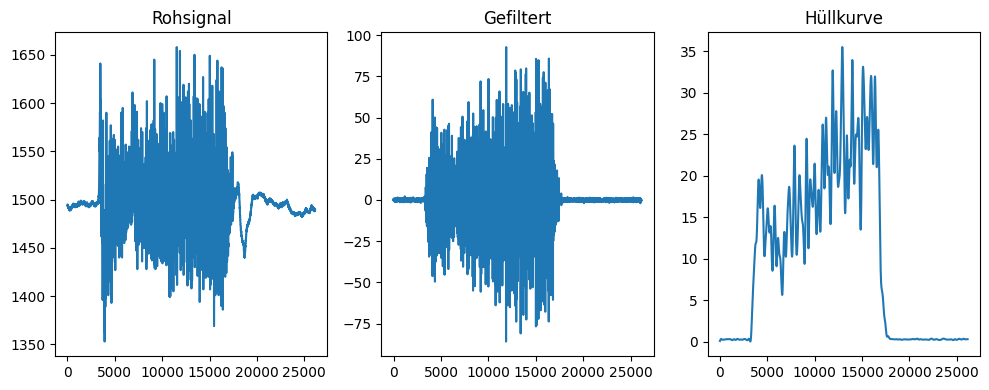

In [56]:

# MVC Plot (Vorverarbeitungsschritte)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(mvc_raw[1]); plt.title("Rohsignal")
plt.subplot(1,3,2)
plt.plot(mvc_filt[1]); plt.title("Gefiltert")
plt.subplot(1,3,3)
plt.plot(mvc_env[1]); plt.title("Hüllkurve")
plt.tight_layout()
plt.show()


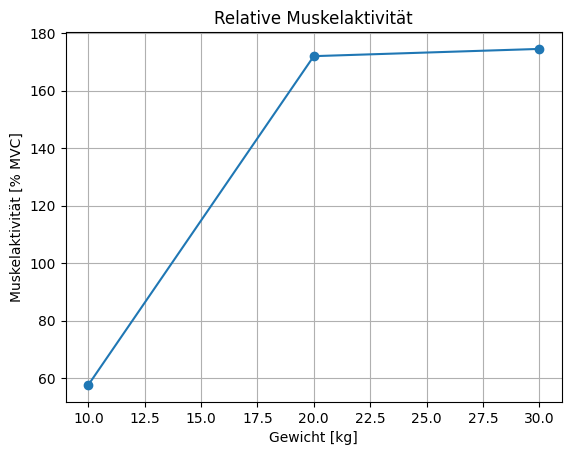

[np.float64(57.62944072361812),
 np.float64(172.02018257567366),
 np.float64(174.53565473863068)]

In [63]:

# Relative Muskelaktivität (Experiment 2)
weights_activity = [np.mean(env)/MVC*100 for env in weights_env]
weights_percent = [10, 20, 30]

plt.figure()
plt.plot(weights_percent, weights_activity, 'o-')
plt.xlabel("Gewicht [kg]")
plt.ylabel("Muskelaktivität [% MVC]")
plt.title("Relative Muskelaktivität")
plt.grid()
plt.show()

weights_activity


In [49]:

# Frequenzanalyse Funktion
def power_spectrum(signal, fs):
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    power = np.abs(np.fft.rfft(signal))**2
    return freqs, power


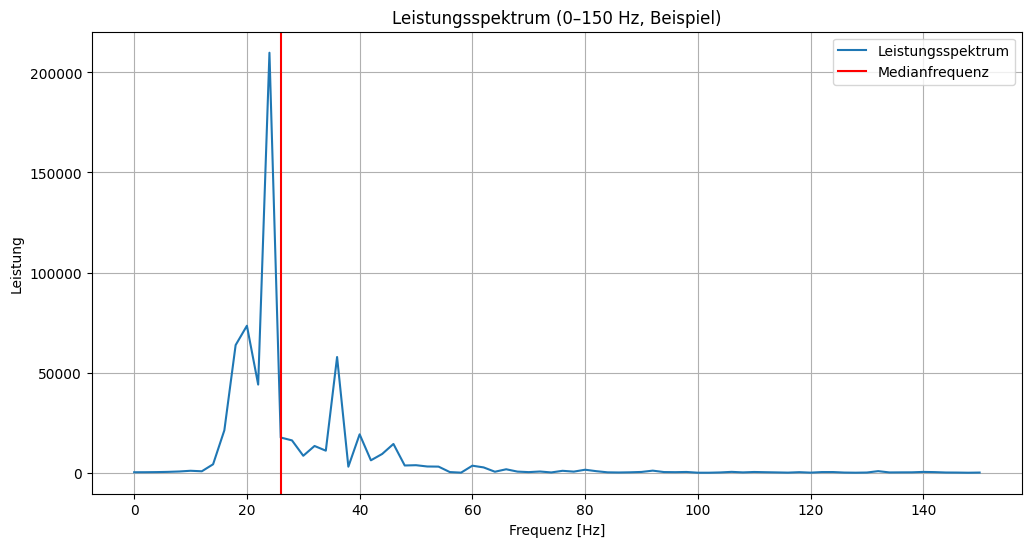

In [78]:
# Ermüdungsanalyse (Experiment 3)
median_freqs = []

plt.figure(figsize=(12,6))

for i, sig in enumerate(fatigue_filt):
    n = len(sig)
    segments = [
        sig[int(0.1*n):int(0.1*n+0.5*fs)],
        sig[int(0.5*n):int(0.5*n+0.5*fs)],
        sig[int(0.8*n):int(0.8*n+0.5*fs)]
    ]
    
    for j, seg in enumerate(segments):
        f, p = power_spectrum(seg, fs)

        # Frequenzbereich auf 0–150 Hz begrenzen
        mask = f <= 150
        f_use = f[mask]
        p_use = p[mask]

        # Medianfrequenz berechnen
        area = cumulative_trapezoid(p_use, f_use, initial=0)
        mf = f_use[np.where(area >= area[-1]/2)[0][0]]
        median_freqs.append(mf)

        # Beispielplot (nur ein Spektrum)
        if i == 0 and j == 0:
            plt.plot(f_use, p_use, label="Leistungsspektrum")
            plt.axvline(mf, color='r', label="Medianfrequenz")

plt.xlabel("Frequenz [Hz]")
plt.ylabel("Leistung")
plt.title("Leistungsspektrum (0–150 Hz, Beispiel)")
plt.legend()
plt.grid()
plt.show()


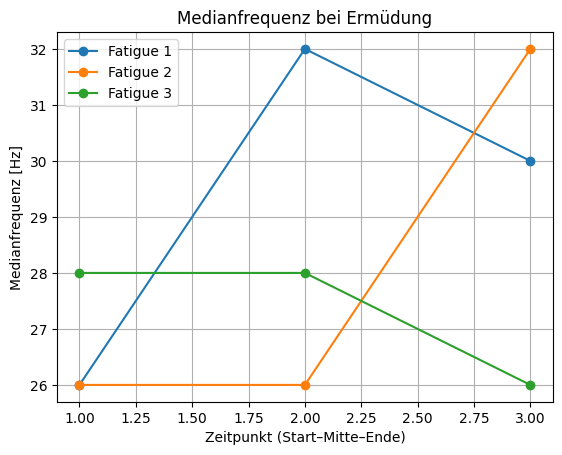

In [80]:

# Medianfrequenzen über Zeit
mf = np.array(median_freqs).reshape(3,3)

plt.figure()
for i in range(3):
    plt.plot([1,2,3], mf[i], 'o-', label=f'Fatigue {i+1}')

plt.xlabel("Zeitpunkt (Start–Mitte–Ende)")
plt.ylabel("Medianfrequenz [Hz]")
plt.title("Medianfrequenz bei Ermüdung")
plt.legend()
plt.grid()
plt.show()
